# Project 3: Web APIs & Classification

## Problem Statement

For this project, we will be using Reddit's API to collect posts from two subreddits and 
then use NLP to train a classifier on which subreddit a given post came from. This is a binary classification problem. Correct classification of posts in the forum is crucial as it enables users to be able to find the right information in the right place.

## Executive Summary

In this text classification project, we will attempt to classify posts from two subreddit forums: MachineLearning and ArtificialIntelligence. In view of the close similarity between thee two topics, we will explore using three different classification models (LogisticRegression, Naive Bayes and GradientBoostingClassifier) and evaluate its performance based on the accuracy score. The following data science process will be carried out.
-  Define problem statement
-  Gather Data
-  Explore Data
-  Data Cleaning & Pre-processing
-  Create Model
-  Evaluate Model
-  Answer Problem
-  Conclusion and Recommendation

 Import Libraries

In [1]:
# Standard data science imports:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# regex
import re

# Import nltk library
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize

# Import Models
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,HashingVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

# Import Metrices
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# settings to see all columns / rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)


## Data Import

Please refer to jupyter notebook on the codes for data download. The downloaded data has been saved to 2 files: ai.csv, ml.csv. We will import both files in this section.

In [2]:
## Data Import (subreddit : artificialintelligence, machinelearning)
data_ai = pd.read_csv('../dataset/ai.csv')
data_ml = pd.read_csv('../dataset/ml.csv')

## Data Check

Let check the size of our dataset to ensure it is sufficient for our modeling tasks.

In [3]:
data_ai.shape, data_ml.shape

((2494, 107), (2460, 107))

In [4]:
data_ai.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2494 entries, 0 to 2493
Columns: 107 entries, Unnamed: 0 to crosspost_parent
dtypes: bool(26), float64(23), int64(11), object(47)
memory usage: 1.6+ MB


In [5]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2460 entries, 0 to 2459
Columns: 107 entries, Unnamed: 0 to link_flair_template_id
dtypes: bool(26), float64(24), int64(11), object(46)
memory usage: 1.6+ MB


In [6]:
cols = ['selftext','title','subreddit']
data_ai[cols].head()

selftext  \
0  NaN                                                                                                                                                                                                                                                                                                                                                                                                                                              
1  NaN                                                                                                                                                                                                                                                                                                                                                                                                                                              
2  NaN                                                                                                                                                                                                                                                                                                                                                                                                                                              
3   **Download:** https://www.mathworks.com/tagteam/89565\_80823v00\_machine\_learning\_section3\_ebook\_v05.pdf                                                                                                                                                                                                                                                                                                                                    
4  Artificial Intelligence is making  revolutionary changes with digital  learning solutions that introduce a  novel approach in imparting  education to students with varied  capabilities and interest.\n\nVisit: [https://www.primafelicitas.com/artificial-intelligence-in-education-and-learning/](https://www.primafelicitas.com/artificial-intelligence-in-education-and-learning/)\n\n&amp;#x200B;\n\nhttps://i.redd.it/i8ahpb52ygt31.png   

                                                   title   subreddit  
0  AI In Wildlife Conservation                            artificial  
1  Hitachi's Train Station of the Future                  artificial  
2  Neural networks taught to "read minds" in real time    artificial  
3  Applying Unsupervised Learning - MathWorks (Download)  artificial  
4  How AI is Revolutionizing Education and Learning?      artificial

In [7]:
data_ml[cols].head()

selftext  \
0  What're  some good datasets for image classification projects other than the  MNISTs out there. I'm still a beginner, but I'm looking for a  challenging project, that I'll spend a lot of time tuning, to push me  closer to that intermediate stage.\n\nAppreciate any suggestions and thank you                                                                                                                                                                                                                                                       
1  He said Since OpenAI still has not changed misleading blog post about "solving the Rubik's cube",  I attach detailed analysis, comparing what they say and imply with what they actually did. IMHO most would not be obvious to nonexperts.  Please zoom in to read &amp; judge for yourself.\n\n&amp;#x200B;\n\nThis seems right, what do you think?\n\n&amp;#x200B;\n\n[https://twitter.com/GaryMarcus/status/1185679169360809984](https://twitter.com/GaryMarcus/status/1185679169360809984)\n\n&amp;#x200B;\n\nhttps://i.redd.it/nmenqh6yolt31.jpg   
2  https://twitter.com/SchoolOfAIOffic/status/1185499979521150976\n\nWow, just when you thought it wouldn't get any worse for Siraj lol                                                                                                                                                                                                                                                                                                                                                                                                                     
3  NaN                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
4  Chip Huyen gives a comprehensive overview of some of the most important evaluation metrics in language modeling.\n\n&amp;#x200B;\n\n[https://thegradient.pub/understanding-evaluation-metrics-for-language-models/](https://thegradient.pub/understanding-evaluation-metrics-for-language-models/)                                                                                                                                                                                                                                                       

                                                                                                         title  \
0  [P] What're some good datasets for image classification projects?                                             
1  [D] Gary Marcus Tweet on OpenAI still has not changed misleading blog post about "solving the Rubik's cube"   
2  [N] School of AI, founded by Siraj Raval, severs ties with Siraj Raval over recents scandals                  
3  [R] Relation learning in a neurocomputational architecture supports cross-domain transfer                     
4  [D] Evaluation Metrics for Language Modeling                                                                  

         subreddit  
0  MachineLearning  
1  MachineLearning  
2  MachineLearning  
3  MachineLearning  
4  MachineLearning

In [8]:
#check null values in ai selftext
print('null rows: ',data_ai['selftext'].isnull().sum())

null rows:  1846


In [9]:
#check null values in ml selftext
print('null rows: ',data_ml['selftext'].isnull().sum())

null rows:  326


## Data Cleaning

In this section, we will proceed to clean the data. These include:
- make a copy of the dataframe before cleaning: data_mi_c, data_ai_c
- fill null values for 'selftext' with 'title'
- drop null rows if any
- check for duplicated rows based on 'selftext' and drop them if necessary
- remove url link in 'selftext'

In [10]:
#make a copy of data_ml before cleaning
data_ml_c = data_ml[['selftext','title','subreddit']].copy()

#fill null selftext with title
data_ml_c['selftext'] = data_ml_c['selftext'].fillna(data_ml_c['title'])
data_ml_c.head(3)

selftext  \
0  What're  some good datasets for image classification projects other than the  MNISTs out there. I'm still a beginner, but I'm looking for a  challenging project, that I'll spend a lot of time tuning, to push me  closer to that intermediate stage.\n\nAppreciate any suggestions and thank you                                                                                                                                                                                                                                                       
1  He said Since OpenAI still has not changed misleading blog post about "solving the Rubik's cube",  I attach detailed analysis, comparing what they say and imply with what they actually did. IMHO most would not be obvious to nonexperts.  Please zoom in to read &amp; judge for yourself.\n\n&amp;#x200B;\n\nThis seems right, what do you think?\n\n&amp;#x200B;\n\n[https://twitter.com/GaryMarcus/status/1185679169360809984](https://twitter.com/GaryMarcus/status/1185679169360809984)\n\n&amp;#x200B;\n\nhttps://i.redd.it/nmenqh6yolt31.jpg   
2  https://twitter.com/SchoolOfAIOffic/status/1185499979521150976\n\nWow, just when you thought it wouldn't get any worse for Siraj lol                                                                                                                                                                                                                                                                                                                                                                                                                     

                                                                                                         title  \
0  [P] What're some good datasets for image classification projects?                                             
1  [D] Gary Marcus Tweet on OpenAI still has not changed misleading blog post about "solving the Rubik's cube"   
2  [N] School of AI, founded by Siraj Raval, severs ties with Siraj Raval over recents scandals                  

         subreddit  
0  MachineLearning  
1  MachineLearning  
2  MachineLearning

In [11]:
#make a copy of data_ai before cleaning
data_ai_c = data_ai[['selftext','title','subreddit']].copy()

#fill null selftext with title
data_ai_c['selftext'] = data_ai_c['selftext'].fillna(data_ai_c['title'])
data_ai_c.head(3)

selftext  \
0  AI In Wildlife Conservation                           
1  Hitachi's Train Station of the Future                 
2  Neural networks taught to "read minds" in real time   

                                                 title   subreddit  
0  AI In Wildlife Conservation                          artificial  
1  Hitachi's Train Station of the Future                artificial  
2  Neural networks taught to "read minds" in real time  artificial

Check and fill null values for the column 'selftext'

In [12]:
#drop null values
print('null rows: ',data_ai_c['selftext'].isnull().sum())
data_ai_c.dropna(axis=0, subset=['selftext'],inplace=True)

#check no. of rows after dropping null
print('len(data_ai_c)(after) : ',len(data_ai_c))

null rows:  0
len(data_ai_c)(after) :  2494


In [13]:
#drop null values
print('null rows: ',data_ml_c['selftext'].isnull().sum())
data_ml_c.dropna(axis=0, subset=['selftext'],inplace=True)

#check no. of rows after dropping null
print('len(data_ml)(after) : ',len(data_ml_c))

null rows:  0
len(data_ml)(after) :  2460


Check for duplicated posts based on 'selftext' and dropped them.

In [14]:
#check for duplicated posts (artificial intelligence)
print(data_ai_c[data_ai_c.duplicated(['selftext'])]['selftext'].sort_values().count())

#drop dupplicated post (artificial intelligence)
data_ai_c.drop_duplicates(subset=['selftext'],inplace=True)
data_ai_c.shape

1507


(987, 3)

In [15]:
#check for duplicated posts (machine learning)
print(data_ml_c[data_ml_c.duplicated(['selftext'])]['selftext'].sort_values().count())

#drop dupplicated post (machine learning)
data_ml_c.drop_duplicates(subset=['selftext'],inplace=True)
data_ml_c.shape

1505


(955, 3)

In [16]:
#remove url link
data_ai_c['selftext'] = data_ai_c['selftext'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
data_ml_c['selftext'] = data_ml_c['selftext'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)


In [17]:
data_ml_c.head(2)

selftext  \
0  What're  some good datasets for image classification projects other than the  MNISTs out there. I'm still a beginner, but I'm looking for a  challenging project, that I'll spend a lot of time tuning, to push me  closer to that intermediate stage.\n\nAppreciate any suggestions and thank you                                                                                               
1  He said Since OpenAI still has not changed misleading blog post about "solving the Rubik's cube",  I attach detailed analysis, comparing what they say and imply with what they actually did. IMHO most would not be obvious to nonexperts.  Please zoom in to read &amp; judge for yourself.\n\n&amp;#x200B;\n\nThis seems right, what do you think?\n\n&amp;#x200B;\n\n[\n\n&amp;#x200B;\n\n   

                                                                                                         title  \
0  [P] What're some good datasets for image classification projects?                                             
1  [D] Gary Marcus Tweet on OpenAI still has not changed misleading blog post about "solving the Rubik's cube"   

         subreddit  
0  MachineLearning  
1  MachineLearning

In [18]:
data_ai_c.head(2)

selftext  \
0  AI In Wildlife Conservation             
1  Hitachi's Train Station of the Future   

                                   title   subreddit  
0  AI In Wildlife Conservation            artificial  
1  Hitachi's Train Station of the Future  artificial

## Data Merge 
We have 2 dataframes earlier on: data_ai_c, data_ml_c. We will
- combine both dataframes into data_all

In [19]:
data_ai_c.shape, data_ml_c.shape

((987, 3), (955, 3))

In [20]:
data_all = data_ai_c.append(data_ml_c)

In [21]:
data_all.shape

(1942, 3)

In [22]:
data_all['subreddit'].value_counts()

artificial         987
MachineLearning    955
Name: subreddit, dtype: int64

In [23]:
data_all.isnull().sum()

selftext     0
title        0
subreddit    0
dtype: int64

# Exploratory Data Analysis

In [24]:
#get the textlength of the posts
data_all['textlength'] = data_all['selftext'].apply(lambda s : len(s))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1b3d9240>]],
      dtype=object)

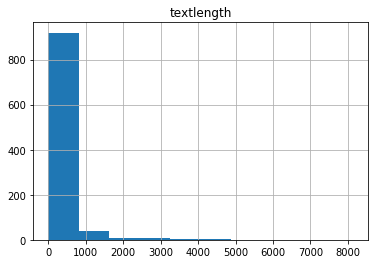

In [25]:
data_all[data_all['subreddit']=='artificial'].hist(bins=10)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1b504d30>]],
      dtype=object)

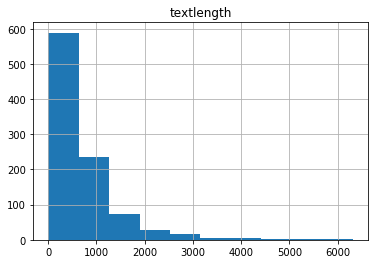

In [26]:
data_all[data_all['subreddit']=='MachineLearning'].hist(bins=10)

##### observations
The length of the posts in machinelearning subforum are more varied and slightly longer than those in artificial intelligence subforum.

# Pre-Processing 
The following tasks will be carried out:
- create a dataframe df containing only 2 features: 'selftext','subreddit' for tokenizing and lemmatizing
- Tokenizing
- Remove stopwords
- Regular Expression (e.g .lower())
- Lemmatizing/Stemming

In [27]:
#create a dataframe df on the combined data for pre-processing
df = data_all[['selftext','subreddit']].copy()

In [28]:
#convert all text to lower case
df['selftext'] = df['selftext'].str.lower()

In [29]:
df['selftext'].head()

0    ai in wildlife conservation                                                                                                                                                                                                           
1    hitachi's train station of the future                                                                                                                                                                                                 
2    neural networks taught to "read minds" in real time                                                                                                                                                                                   
3     **download:**                                                                                                                                                                                                                        
4    artificial intelligence is making  revolutionary ch

## Tokenizing
When we "tokenize" data, we take it and split it up into distinct chunks based on some pattern.

In [30]:
# Import Tokenizer
from nltk.tokenize import RegexpTokenizer

# Instantiate Tokenizer
tokenizer = RegexpTokenizer(r'[A-Za-z]\w+')

In [31]:
# Run tokenizer on column 'selftext'
df['tokenized_text'] = df['selftext'].apply(tokenizer.tokenize) 

In [32]:
df['tokenized_text'].head(5)

0    [ai, in, wildlife, conservation]                                                                                                                                                                                                          
1    [hitachi, train, station, of, the, future]                                                                                                                                                                                                
2    [neural, networks, taught, to, read, minds, in, real, time]                                                                                                                                                                               
3    [download]                                                                                                                                                                                                                                
4    [artificial, intelligence, is, maki

## remove stopwords

In [33]:
#remove stopwords
nltk.download('stopwords')  
# Import stopwords.
from nltk.corpus import stopwords # Import the stop word list

def remove_stopwords(text):
    return [w for w in text if not w in stopwords.words('english')]

# Remove stop words from "tokenize_text"
df['tokenized_text'] = df['tokenized_text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/guathwalow/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
df.head()

selftext  \
0  ai in wildlife conservation                                                                                                                                                                                                              
1  hitachi's train station of the future                                                                                                                                                                                                    
2  neural networks taught to "read minds" in real time                                                                                                                                                                                      
3   **download:**                                                                                                                                                                                                                           
4  artificial intelligence is making  revolutionary changes with digital  learning solutions that introduce a  novel approach in imparting  education to students with varied  capabilities and interest.\n\nvisit: [\n\n&amp;#x200b;\n\n   

    subreddit  \
0  artificial   
1  artificial   
2  artificial   
3  artificial   
4  artificial   

                                                                                                                                                                                            tokenized_text  
0  [ai, wildlife, conservation]                                                                                                                                                                             
1  [hitachi, train, station, future]                                                                                                                                                                        
2  [neural, networks, taught, read, minds, real, time]                                                                                                                                                      
3  [download]                                                                                                                                                                                               
4  [artificial, intelligence, making, revolutionary, changes, digital, learning, solutions, introduce, novel, approach, imparting, education, students, varied, capabilities, interest, visit, amp, x200b]

## Lemmatization

In this section, we will lemmatize the tokenized text from the previous sections to reduce the size of our corpus.

In [35]:
import nltk
nltk.download('wordnet')

# Import lemmatizer. 
from nltk.stem import WordNetLemmatizer

# Instantiate lemmatizer. 
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/guathwalow/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [36]:
def lemmatize_text(text,pos='n'):
    return [lemmatizer.lemmatize(w,pos=pos) for w in text]

In [37]:
# Lemmatize tokens.
df['lemmatize_text'] = df['tokenized_text'].apply(lambda t: lemmatize_text(t,'v'))

In [38]:
# Instantiate stemmer.
from nltk.stem.porter import PorterStemmer

# Instantiate object of class PorterStemmer.
p_stemmer = PorterStemmer()

# Stem tokens.
df['stem_text'] = df['tokenized_text'].apply(lambda t: [p_stemmer.stem(x) for x in t])
#stem_spam = [p_stemmer.stem(i) for i in spam_tokens]

In [39]:
df.head()

selftext  \
0  ai in wildlife conservation                                                                                                                                                                                                              
1  hitachi's train station of the future                                                                                                                                                                                                    
2  neural networks taught to "read minds" in real time                                                                                                                                                                                      
3   **download:**                                                                                                                                                                                                                           
4  artificial intelligence is making  revolutionary changes with digital  learning solutions that introduce a  novel approach in imparting  education to students with varied  capabilities and interest.\n\nvisit: [\n\n&amp;#x200b;\n\n   

    subreddit  \
0  artificial   
1  artificial   
2  artificial   
3  artificial   
4  artificial   

                                                                                                                                                                                            tokenized_text  \
0  [ai, wildlife, conservation]                                                                                                                                                                              
1  [hitachi, train, station, future]                                                                                                                                                                         
2  [neural, networks, taught, read, minds, real, time]                                                                                                                                                       
3  [download]                                                                                                                                                                                                
4  [artificial, intelligence, making, revolutionary, changes, digital, learning, solutions, introduce, novel, approach, imparting, education, students, varied, capabilities, interest, visit, amp, x200b]   

                                                                                                                                                                                 lemmatize_text  \
0  [ai, wildlife, conservation]                                                                                                                                                                   
1  [hitachi, train, station, future]                                                                                                                                                              
2  [neural, network, teach, read, mind, real, time]                                                                                                                                               
3  [download]                                                                                                                                                                                     
4  [artificial, intelligence, make, revolutionary, change, digital, learn, solutions, introduce, novel, approach, impart, education, students, vary, capabilities, interest, visit, amp, x200b]   

                                                                                                                                                            stem_text  
0  [ai, wildlif, conserv]                                                                                                  

In [40]:
#create text feature from lemmatize_text, convert back to strings for countvectorizer
df['text_feature']=df['lemmatize_text'].apply(lambda x: " ".join(x) )

In [41]:
df.shape

(1942, 6)

In [42]:
data_ai_c.shape, data_ml_c.shape

((987, 3), (955, 3))

## Word Clouds

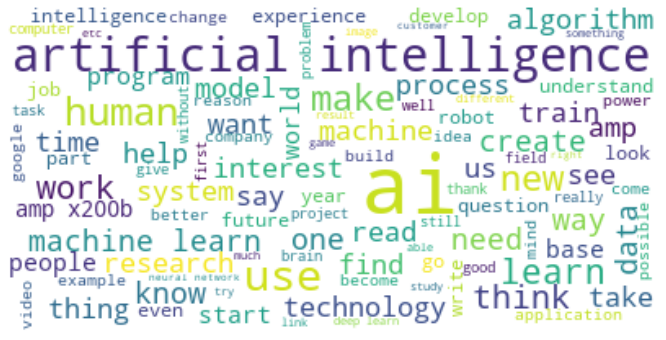

In [43]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#artificial intelligence
df_ai = df[df['subreddit']=='artificial']
wordcloud_ai = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(df_ai['text_feature']))

# Display the generated image:
plt.figure(figsize=(12,6))
plt.imshow(wordcloud_ai, interpolation='bilinear')
plt.axis("off")
plt.show()

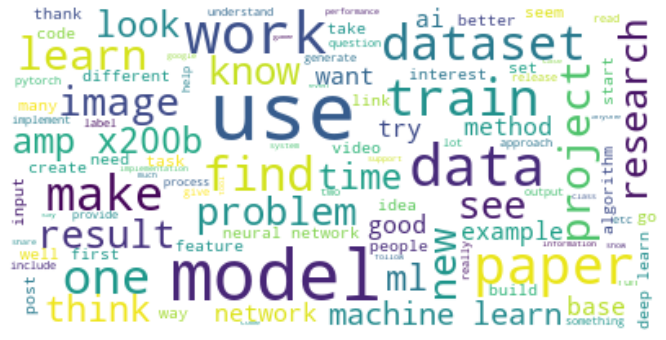

In [44]:
#machine learning
df_ml = df[df['subreddit']=='MachineLearning']
wordcloud_ml = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(df_ml['text_feature']))

# Display the generated image:
plt.figure(figsize=(12,6))
plt.imshow(wordcloud_ml, interpolation='bilinear')
plt.axis("off")
plt.show()

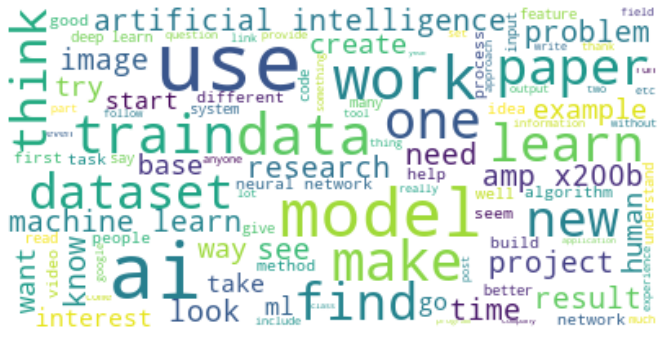

In [45]:
#Combined
#combined
wordcloud_all = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(df['text_feature']))

# Display the generated image:
plt.figure(figsize=(12,6))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis("off")
plt.show()

## Split into Training set, Test set

In this section, we are splitting our entire dataframe df into training set (80% for training, validation) and 20% for testing.

In [46]:
df_train,df_test = train_test_split(df,test_size=0.20, shuffle=True,random_state=42)

In [47]:
df_train.shape,df_test.shape

((1553, 6), (389, 6))

In [48]:
df_train['subreddit'].value_counts()

artificial         789
MachineLearning    764
Name: subreddit, dtype: int64

In [49]:
df_test['subreddit'].value_counts()

artificial         198
MachineLearning    191
Name: subreddit, dtype: int64

In [50]:
df_train = df_train.reset_index(drop=True)

In [51]:
df_test = df_test.reset_index(drop=True)

In [52]:
#check duplicates in train data
print(df_train.shape)
print(df_train[df_train.duplicated(['selftext'])]['selftext'].sort_values().count())
#drop dupplicated post 
df_train.drop_duplicates(subset=['selftext'],inplace=True)
print(df_train.shape)

(1553, 6)
4
(1549, 6)


In [53]:
#check duplicates in test data
print(df_test.shape)
print(df_test[df_test.duplicated(['selftext'])]['selftext'].sort_values().count())
#drop dupplicated post 
df_test.drop_duplicates(subset=['selftext'],inplace=True)
print(df_test.shape)

(389, 6)
1
(388, 6)


# Model Prep

In this section, we will encode our target label to 0/1:
    - 0 for artificial intellegience subreddit
    - 1 for machine learning subreddit
    - get our X and y and do train-test-split to get our training and validation dataset

In [54]:
#encode target label 
#Check for unbalanced classes.
df_train['target'] = df_train['subreddit'].map({'artificial':0, 'MachineLearning':1})
df_train['target'].value_counts()

0    786
1    763
Name: target, dtype: int64

In [55]:
df_test['target'] = df_test['subreddit'].map({'artificial':0, 'MachineLearning':1})
df_test['target'].value_counts()

0    197
1    191
Name: target, dtype: int64

## Split our data into `X` and `y`.

In [56]:
X = df_train['text_feature']
y = df_train['target']

In [57]:
X.shape, y.shape

((1549,), (1549,))

## Baseline Accuracy
The baseline accuracy is the percentage of the majority class, regardless of whether it is 1 or 0. It serves as the benchmark for our model to beat.

In [58]:
y.value_counts(normalize=True)

0    0.507424
1    0.492576
Name: target, dtype: float64

## Train-Test-Split

In [59]:
#split into train set, validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20,stratify=y, shuffle=True,random_state=42)

In [60]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1239,), (1239,), (310,), (310,))

# Modeling

In this section, we will create and evaluate our models for the training dataset as follow:
- Using CountVectorizer
    - do gridsearch to find optimal parameters
    - create coutvectorizer based on optimal parameters
    - Model 1 : Logistic Regression
    - Model 2 : Naive Bayes MultinomialNB
    - Model 3 : GradientBoostingClassifier
- Using TF-IDF
    - do gridsearch to find optimal parameters
    - create tfidfvectorizer based on optimal parameters
    - Model 1 : Logistic Regression
    - Model 2 : Naive Bayes MultinomialNB
    - Model 3 : GradientBoostingClassifier

##  Using CountVectorizer

In this section, we will be using countvectorizer to create our text feature matrix for training and validation.

In [61]:
#get the training data indexes which will be use to get list of common words 
#for each target label
indices = []
for row in X_train.index:
    indices.append(row)

In [62]:
## Instantiate a CountVectorizer 
cvec = CountVectorizer()
cvec.fit(X_train)

# Transform the corpus
X_train_cvec = cvec.transform(X_train)
X_val_cvec = cvec.transform(X_val)

# Create a dataframe to store our feature vectors
df_cvec = pd.DataFrame(X_train_cvec.toarray(),
                       columns=cvec.get_feature_names(), index=indices)


print('size of feature dict : ',len(cvec.get_feature_names()))
df_cvec.head()

size of feature dict :  7400


a13  a2c  a3c  a4  aa  aaai  aaai2020  aacb  aad  aaron  abandon  \
434   0    0    0    0   0   0     0         0     0    0      0         
1431  0    0    0    0   0   0     0         0     0    0      0         
546   0    0    0    0   0   0     0         0     0    0      0         
1285  0    0    0    0   0   0     0         0     0    0      0         
1295  0    0    0    0   0   0     0         0     0    0      0         

      abbeel  abc  abd  abilities  ability  able  absence  absolute  \
434   0       0    0    0          0        0     0        0          
1431  0       0    0    0          0        0     0        0          
546   0       0    0    0          0        0     0        0          
1285  0       0    0    0          1        0     0        0          
1295  0       0    0    0          0        0     0        0          

      absolutely  abstain  abstract  abstractions  abstractive  abstrated  \
434   0           0        0         0             0            0           
1431  0           0        0         0             0            0           
546   0           0        0         0             0            0           
1285  0           0        0         0             0            0           
1295  0           0        0         0             0            0           

      absurd  abtraction  abundant  abusers  ac  ac09  ac19  ac90  academia  \
434   0       0           0         0        0   0     0     0     0          
1431  0       0           0         0        0   0     0     0     0          
546   0       0           0         0        0   0     0     0     0          
1285  0       0           0         0        0   0     0     0     0          
1295  0       0           0         0        0   0     0     0     0          

      academic  academical  academics  academy  acc  accelerate  acceleration  \
434   0         0           0          0        0    0           0              
1431  0         0           0          0        0    0           0              
546   0         0           0          0        0    0           0              
1285  0         0           0          0        0    0           0              
1295  0         0           0          0        0    0           0              

      accelerator  accent  accept  acceptable  access  accessibility  \
434   0            0       0       0           0       0               
1431  0            0       0       0           0       0               
546   0            0       0       0           0       0               
1285  0            0       0       0           0       0               
1295  0            0       0       0           0       0               

      accessible  accidents  acclimatize  accommodate  accompany  accomplish  \
434   0           0          0            0            0          0            
1431  0           0          0            0            0          0            
546   0           0          0            0            0          0            
1285  0           0          0            0            0          0            
1295  0           0          0            0            0          0            

      accord  accordingly  account  accredit  accumulate  accuracies  \
434   0       0            0        0         0           0            
1431  0       0            0        0         0           0            
546   0       0            0        0         0           0            
1285  0       0            0        0         0           0            
1295  0       0            0        0         0           0            

      accuracy  accurate  accurately  accusation  ace  achievable  achieve  \
434   0         0         0           0           0    0           0         
1431  0         0         0           0           0    0           0         
546   0         0         0           0           0    0           0         
1285  0         0         0           0           

In [63]:
# Lets look through the Top 20 words for each target label
target_names=['artificial intelligence','machine learning']
common_words = []
for i in [0,1]:
    word_count = df_cvec[y_train==i].sum(axis=0)
    print (target_names[i], "most common words")
    cw = word_count.sort_values(ascending = False).head(20)
    print (cw)
    common_words.extend(cw.index)

artificial intelligence most common words
ai              505
learn           161
intelligence    143
artificial      135
use             127
would           96 
like            91 
machine         81 
make            80 
data            74 
amp             68 
work            66 
get             66 
think           65 
know            60 
new             59 
time            59 
need            54 
create          52 
take            51 
dtype: int64
machine learning most common words
use         471
learn       438
model       407
data        294
train       248
paper       248
work        233
would       219
network     208
like        207
make        181
amp         157
find        155
one         147
time        146
also        145
know        141
project     140
research    136
get         134
dtype: int64


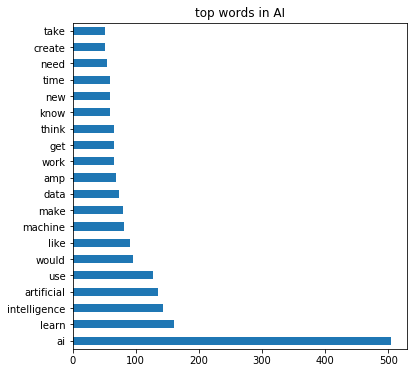

In [64]:
plt.figure(figsize=(6,6))
word_count = df_cvec[y_train==0].sum(axis=0)
word_count.sort_values(ascending = False).head(20).plot(kind='barh',title='top words in AI')

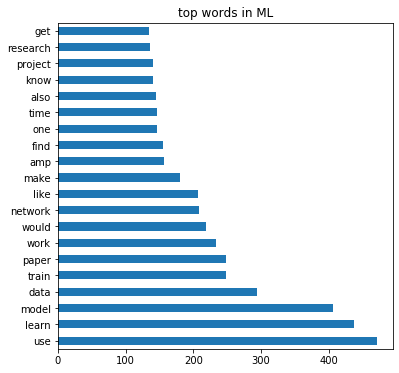

In [65]:
plt.figure(figsize=(6,6))
word_count = df_cvec[y_train==1].sum(axis=0)
word_count.sort_values(ascending = False).head(20).plot(kind='barh',title='top words in ML')

We can see that there are a number of common top words in both categories, e.g learn, use, data. This is expected as these 2 topics (artificial intelligence and machine learning) are closely related.

In [66]:
#we will remove the top common words in the 2 categories using stopwords
#customised stop words : top common words that appear in both targets
c_stopwords = ['learn','data','use','work','like','amp']


### Pipeline
Our pipeline will consist of two stages:
1. An instance of `CountVectorizer`
2. A `LogisticRegression` instance

In [67]:
pipe1 = Pipeline([
    ('cvec', CountVectorizer(stop_words=c_stopwords)),
    ('lr', LogisticRegression())
])

### GridSearchCV
Since we want to tune over the `CountVectorizer`, so we'll load our `pipeline` object into `GridSearchCV`.

In [68]:
pipe1_params = {
    'cvec__max_features': [2500, 3000, 3500,7000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}
gs = GridSearchCV(pipe1, param_grid=pipe1_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

0.847457627118644


/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'cvec__max_df': 0.9,
 'cvec__max_features': 3500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2)}

In [69]:
gs.score(X_train, y_train)

0.9911218724778047

In [70]:
gs.score(X_val, y_val)

0.8483870967741935

These are the optimal parameters obtained in the gridsearchcv. 
{'cvec__max_df': 0.9,
 'cvec__max_features': 2500,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2)}. 

### create countvectorizer with optimal parameters

In [71]:
#use optimal parameters from GridSearch
cvec = CountVectorizer(max_df=0.9,max_features=2500,min_df=2,ngram_range=(1,2),stop_words=c_stopwords)
cvec.fit(X_train)
X_train_cvec = cvec.transform(X_train)
X_val_cvec = cvec.transform(X_val)

# Create a dataframe to store our feature vectors
df_cvec = pd.DataFrame(X_train_cvec.toarray(),columns = cvec.get_feature_names())

print('size of feature dict : ',len(cvec.get_feature_names()))
df_cvec.head()

size of feature dict :  2500


a2c  a3c  ability  able  absolutely  abstract  ac  academia  academic  \
0  0    0    0        0     0           0         0   0         0          
1  0    0    0        0     0           0         0   0         0          
2  0    0    0        0     0           0         0   0         0          
3  0    0    1        0     0           0         0   0         0          
4  0    0    0        0     0           0         0   0         0          

   accelerate  accept  access  accord  account  accuracy  accurate  \
0  0           0       0       0       0        0         0          
1  0           0       0       0       0        0         0          
2  0           0       0       0       0        0         0          
3  0           0       0       0       0        0         0          
4  0           0       0       0       0        0         0          

   accurately  achieve  across  act  action  action recognition  activation  \
0  0           0        0       0    0       0                   0            
1  0           0        0       0    0       0                   0            
2  0           0        0       0    0       0                   0            
3  0           0        0       0    0       0                   0            
4  0           0        0       0    0       0                   0            

   activation function  active  actively  actual  actually  adam  adapt  \
0  0                    0       0         0       0         0     0       
1  0                    0       0         0       0         0     0       
2  0                    0       0         0       0         0     0       
3  0                    0       0         0       0         0     0       
4  0                    0       0         0       0         0     0       

   adaptation  add  addition  additional  address  adjust  adoption  advance  \
0  0           0    0         0           0        0       0         0         
1  0           0    0         0           0        0       0         0         
2  0           0    0         0           0        0       0         0         
3  0           0    0         0           0        0       0         0         
4  0           0    0         0           0        0       0         0         

   advancements  advantage  adversarial  adversarial attack  advice  affect  \
0  0             0          0            0                   0       0        
1  0             0          0            0                   0       0        
2  0             0          0            0                   0       0        
3  0             0          0            0                   0       0        
4  0             0          0            0                   0       0        

   afraid  afterwards  age  agent  agents  agi  agnostic  ago  agree  ahead  \
0  0       0           0    0      0       0    0         0    0      0       
1  0       0           0    0      1       0    0         0    0      0       
2  0       0           0    0      0       0    0         0    0      0       
3  0       0           0    0      0       0    0         0    0      0       
4  0       0           0    0      0       0    0         0    0      0       

   ai  ai agents  ai application  ai applications  ai could  ai deep  \
0  0   0          0               0                0         0         
1  1   1          0               0                0         0         
2  0   0          0               0                0         0         
3  0   0          0               0                0         0         
4  0   0          0               0                0         0         

   ai development  ai experts  ai generate  ai machine  ai ml  ai model  \
0  0               0           0            0           0      0          
1  0               0           0            0           0      0          
2  0               0           0            0           0      0          
3  0               0           0   

In [72]:
X_train.shape,y_train.shape

((1239,), (1239,))

### countvectorizer word frequency

2500


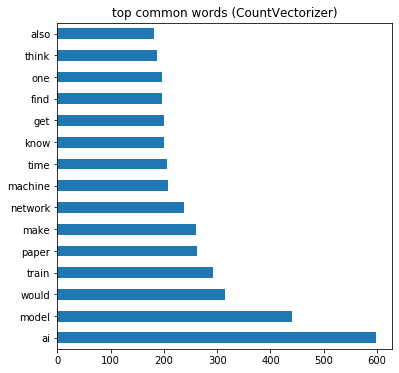

In [73]:
# Which words appear the most?
plt.figure(figsize=(6,6))

word_counts = df_cvec.sum(axis=0)
print(len(word_counts))
word_counts.sort_values(ascending = False).head(15).plot(kind='barh',title='top common words (CountVectorizer)')

In [74]:
def train_model(model_list,X_train,y_train,X_val,y_val):
    cv_results = []
    cv_means = 0
    df_scores = pd.DataFrame(columns=['model','cv_score','train_score','val_score','test_score'])
    
    for m in model_list :
        print('training model : ',m)
        model = m
        model_list.fit(X_train,y_train)
        cv_results=cross_val_score(model_list, X_train, y_train, scoring = "accuracy", cv = 5, n_jobs=1)
        cv_mean = cv_results.mean()
        train_score = model.score(X_train,y_train) 
        val_score = model.score(X_val,y_val)
        df_score = df.score.append(model,cv_mean,train_score,val_score,'')
    return df_score

In [75]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier

models=[]
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', MultinomialNB()))
models.append(('ADAB', AdaBoostClassifier()))
models.append(('GB', GradientBoostingClassifier()))


# Fit the models and score them
names = []
scores = []
for name, model in models:
    model.fit(X_train_cvec, y_train)
    y_pred = model.predict(X_val_cvec)
    scores.append(accuracy_score(y_val, y_pred))
    names.append(name)
    
# Print out "scores" and "names".
print(scores)
print(names)

# Compare the accuracy of the models, sorting your answer in descending order of score.

models_comparison = pd.DataFrame({'Name':names, 'Score':scores})
models_comparison.sort_values(by='Score', ascending = False, inplace=True)
models_comparison


/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.8516129032258064, 0.8451612903225807, 0.8451612903225807, 0.8387096774193549, 0.832258064516129]
['LR', 'DT', 'NB', 'ADAB', 'GB']


Name     Score
0  LR    0.851613
1  DT    0.845161
2  NB    0.845161
3  ADAB  0.838710
4  GB    0.832258

### Model 1- Logistic Regression (countvectorizer)

In [76]:
#create a df_scores dataframe to store the model scores for comparison
df_scores = pd.DataFrame(columns=['model','cv_score','train_score','val_score','test_score'])
df_scores.head()

Empty DataFrame
Columns: [model, cv_score, train_score, val_score, test_score]
Index: []

In [77]:
#instantiate our model and do cross validation on train data
lr = LogisticRegression()
cv = cross_val_score(lr,X_train_cvec,y_train,cv=5)
cv_mean = cv.mean()
print(cv)
print('cv mean score: ',cv_mean)

[0.85483871 0.84677419 0.79032258 0.86693548 0.84615385]
cv mean score:  0.8410049627791564


/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [78]:
#fit our model and save it as model_1
model_1 = lr.fit(X_train_cvec,y_train)

# Generate our predictions!
y_preds_1 = model_1.predict(X_val_cvec)

print('Model: Logistic Regression (using countvectorizer)')

# Score our model on the training set.
train_score = model_1.score(X_train_cvec, y_train)
print('training score : ',train_score)

# Score our model on the validation set.
val_score = model_1.score(X_val_cvec, y_val)
print('validation score :',val_score)

# Save score to dataframe df_scores
df_scores = df_scores.append(pd.DataFrame([['model_1_lr_cvec',cv_mean,train_score,val_score,'']],
                columns=['model','cv_score','train_score','val_score','test_score']))

Model: Logistic Regression (using countvectorizer)
training score :  0.9854721549636803
validation score : 0.8516129032258064


##### observations:
The training score is 99% and the validation score is 80%. This shows that logistic regression model is extremely overfit.

### Model 2 - Naive Bayes (countvectorizer)

In [79]:
# Instantiate our model and do cross-valiation on train data
nb = MultinomialNB()
cv = cross_val_score(nb,X_train_cvec,y_train,cv=5)
cv_mean = cv.mean()
print(cv)
print('cv mean score: ',cv_mean)

[0.83064516 0.86290323 0.81451613 0.83064516 0.90688259]
cv mean score:  0.8491184537024944


In [80]:
# Fit our model and save it as model_2
model_2 = nb.fit(X_train_cvec, y_train)

# Generate our predictions!
y_preds_2 = model_2.predict(X_val_cvec)
print('Model: Naive Bayes (using countvectorizer)')

# Score our model on the training set.
train_score = model_2.score(X_train_cvec, y_train)
print('training score : ',train_score)

# Score our model on the testing set.
val_score = model_2.score(X_val_cvec, y_val)
print('validation score :',val_score)

# Save score to dataframe df_scores
df_scores = df_scores.append(pd.DataFrame([['model_2_nb_cvec',cv_mean,train_score,val_score,'']],
                columns=['model','cv_score','train_score','val_score','test_score']))

Model: Naive Bayes (using countvectorizer)
training score :  0.9096045197740112
validation score : 0.8451612903225807


##### observations:
The training score is 90% and the validation score is 80%. This shows that naive bayes model is overfit. However, as compared to logistic regression model, this model has less overfitting issues. 

Let's take a look at the top features for both target labels in naive bayes.

In [126]:
#prob for positive class - ml
pos_class_prob_sorted = nb.feature_log_prob_[1, :].argsort()
#prob for negative class - ai
neg_class_prob_sorted = nb.feature_log_prob_[0, :].argsort()

#getting the top 10 features 
ai_top_features = np.take(cvec.get_feature_names(), neg_class_prob_sorted)[-15:]
ml_top_features = np.take(cvec.get_feature_names(), pos_class_prob_sorted)[-15:]

In [130]:
list(ai_top_features)

['take',
 'create',
 'need',
 'new',
 'time',
 'know',
 'think',
 'get',
 'make',
 'machine',
 'would',
 'artificial intelligence',
 'artificial',
 'intelligence',
 'ai']

In [128]:
list(ml_top_features)

['ml',
 'get',
 'research',
 'project',
 'know',
 'also',
 'time',
 'one',
 'find',
 'make',
 'network',
 'would',
 'train',
 'paper',
 'model']

In [84]:
df_scores

model  cv_score  train_score  val_score test_score
0  model_1_lr_cvec  0.841005  0.985472     0.851613            
0  model_2_nb_cvec  0.849118  0.909605     0.845161

### Model 3 - GradientBoostingClassifier (countvectorizer)

In [85]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import make_classification

gboost = GradientBoostingClassifier()
gb_params = {
    'n_estimators' : [50,100],
    'max_depth' : [1,2,3,4,5],
    'learning_rate' : [0.1,0.5,1]
}
gb_gs = GridSearchCV(gboost, param_grid=gb_params, cv=3)
gb_gs.fit(X_train_cvec, y_train)
print(gb_gs.best_score_)
gb_gs.best_params_

0.8450363196125908


{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}

In [86]:
cv_score = gb_gs.best_score_

train_score = gb_gs.score(X_train_cvec, y_train)
train_score

0.9628732849071832

In [87]:
val_score = gb_gs.score(X_val_cvec, y_val)
val_score

0.8354838709677419

In [88]:
# Save score to dataframe df_scores
df_scores = df_scores.append(pd.DataFrame([['model_3_gbs_cvec',cv_score,train_score,val_score,'']],
                columns=['model','cv_score','train_score','val_score','test_score']))

In [89]:
df_scores

model  cv_score  train_score  val_score test_score
0  model_1_lr_cvec   0.841005  0.985472     0.851613            
0  model_2_nb_cvec   0.849118  0.909605     0.845161            
0  model_3_gbs_cvec  0.845036  0.962873     0.835484

##### observations:
On model 1,2,3, Naive Bayes has the least overfitting issues.

## Using TF-IDF vectorizer

### Pipeline

In [90]:
pipe2 = Pipeline([
    ('tvec', TfidfVectorizer(stop_words=c_stopwords)),
    ('lr', LogisticRegression())
])

### GridSearchCV

In [91]:
pipe2_params = {
    'tvec__max_features': [2500, 3000, 3500,5000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range': [(1,1), (1,2)]
}
gs = GridSearchCV(pipe2, param_grid=pipe2_params, cv=3)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver 

0.8668280871670703


/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


{'tvec__max_df': 0.9,
 'tvec__max_features': 2500,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 1)}

### create TF-IDF vectorizer with optimal parameters

In [92]:
# Instantiate a TfidfVectorizer
tvec = TfidfVectorizer(max_df=0.9,max_features=2500,min_df=2,ngram_range=(1,2),stop_words=c_stopwords)
tvec.fit(X_train)

# Transform the corpus
X_train_tvec = tvec.transform(X_train)
X_val_tvec = tvec.transform(X_val)

# Create a dataframe to store our feature vectors
df_tvec = pd.DataFrame(X_train_tvec.toarray(),columns = tvec.get_feature_names())

print('size of feature dict : ',len(tvec.get_feature_names()))
df_tvec.head()

size of feature dict :  2500


a2c  a3c   ability  able  absolutely  abstract   ac  academia  academic  \
0  0.0  0.0  0.000000  0.0   0.0         0.0       0.0  0.0       0.0        
1  0.0  0.0  0.000000  0.0   0.0         0.0       0.0  0.0       0.0        
2  0.0  0.0  0.000000  0.0   0.0         0.0       0.0  0.0       0.0        
3  0.0  0.0  0.142776  0.0   0.0         0.0       0.0  0.0       0.0        
4  0.0  0.0  0.000000  0.0   0.0         0.0       0.0  0.0       0.0        

   accelerate  accept  access  accord  account  accuracy  accurate  \
0  0.0         0.0     0.0     0.0     0.0      0.0       0.0        
1  0.0         0.0     0.0     0.0     0.0      0.0       0.0        
2  0.0         0.0     0.0     0.0     0.0      0.0       0.0        
3  0.0         0.0     0.0     0.0     0.0      0.0       0.0        
4  0.0         0.0     0.0     0.0     0.0      0.0       0.0        

   accurately  achieve  across  act  action  action recognition  activation  \
0  0.0         0.0      0.0     0.0  0.0     0.0                 0.0          
1  0.0         0.0      0.0     0.0  0.0     0.0                 0.0          
2  0.0         0.0      0.0     0.0  0.0     0.0                 0.0          
3  0.0         0.0      0.0     0.0  0.0     0.0                 0.0          
4  0.0         0.0      0.0     0.0  0.0     0.0                 0.0          

   activation function  active  actively  actual  actually  adam  adapt  \
0  0.0                  0.0     0.0       0.0     0.0       0.0   0.0     
1  0.0                  0.0     0.0       0.0     0.0       0.0   0.0     
2  0.0                  0.0     0.0       0.0     0.0       0.0   0.0     
3  0.0                  0.0     0.0       0.0     0.0       0.0   0.0     
4  0.0                  0.0     0.0       0.0     0.0       0.0   0.0     

   adaptation  add  addition  additional  address  adjust  adoption  advance  \
0  0.0         0.0  0.0       0.0         0.0      0.0     0.0       0.0       
1  0.0         0.0  0.0       0.0         0.0      0.0     0.0       0.0       
2  0.0         0.0  0.0       0.0         0.0      0.0     0.0       0.0       
3  0.0         0.0  0.0       0.0         0.0      0.0     0.0       0.0       
4  0.0         0.0  0.0       0.0         0.0      0.0     0.0       0.0       

   advancements  advantage  adversarial  adversarial attack  advice  affect  \
0  0.0           0.0        0.0          0.0                 0.0     0.0      
1  0.0           0.0        0.0          0.0                 0.0     0.0      
2  0.0           0.0        0.0          0.0                 0.0     0.0      
3  0.0           0.0        0.0          0.0                 0.0     0.0      
4  0.0           0.0        0.0          0.0                 0.0     0.0      

   afraid  afterwards  age  agent    agents  agi  agnostic  ago  agree  ahead  \
0  0.0     0.0         0.0  0.0    0.000000  0.0  0.0       0.0  0.0    0.0     
1  0.0     0.0         0.0  0.0    0.381561  0.0  0.0       0.0  0.0    0.0     
2  0.0     0.0         0.0  0.0    0.000000  0.0  0.0       0.0  0.0    0.0     
3  0.0     0.0         0.0  0.0    0.000000  0.0  0.0       0.0  0.0    0.0     
4  0.0     0.0         0.0  0.0    0.000000  0.0  0.0       0.0  0.0    0.0     

         ai  ai agents  ai application  ai applications  ai could  ai deep  \
0  0.000000  0.00000    0.0             0.0              0.0       0.0       
1  0.165939  0.45151    0.0             0.0              0.0       0.0       
2  0.000000  0.00000    0.0             0.0              0.0       0.0       
3  0.000000  0.00000    0.0             0.0              0.0       0.0       
4  0.000000  0.00000    0.0             0.0              0.0       0.0       

   ai development  ai experts  ai generate  ai machine  ai ml  ai model  \
0  0.0             0.0         0.0          0.0         0.0    0.0        
1  0.0             0.0         0.0          0.0         0.0    0.0        
2  0.0             0.0         0.0          0.0   

### TF-IDF word frequency

2500


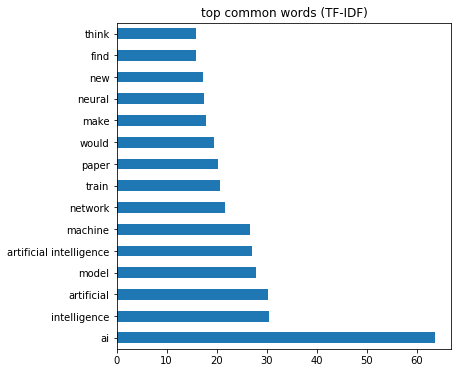

In [93]:
# Which words appear the most?
plt.figure(figsize=(6,6))
word_counts = df_tvec.sum(axis=0)
print(len(word_counts))
word_counts.sort_values(ascending = False).head(15).plot(kind='barh',title='top common words (TF-IDF)')

### Model 4 - Logistic Regression (TF-IDF)

In [94]:
cv = cross_val_score(lr,X_train_tvec,y_train,cv=5)
cv_mean = cv.mean()
print(cv)
print('mean cv score :',cv_mean)

[0.84274194 0.87903226 0.85483871 0.87096774 0.88663968]
mean cv score : 0.8668440642549301


/Users/guathwalow/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [95]:
model_4 = lr.fit(X_train_tvec,y_train)

# Generate our predictions!
y_preds_4 = model_4.predict(X_val_tvec)

print('Model: Logistic Regression (using tf-idf)')

# Score our model on the training set.
train_score = model_4.score(X_train_tvec, y_train)
print('training score : ',train_score)

# Score our model on the testing set.
val_score = model_4.score(X_val_tvec, y_val)
print('validation score :',val_score)

# Save score to dataframe df_scores
df_scores = df_scores.append(pd.DataFrame([['model_4_lr_tvec',cv_mean,train_score,val_score,'']],
                columns=['model','cv_score','train_score','val_score','test_score']))

Model: Logistic Regression (using tf-idf)
training score :  0.9451170298627926
validation score : 0.8774193548387097


### Model 5 - Naive Bayes (TF-IDF)

In [96]:
cv = cross_val_score(nb,X_train_tvec,y_train,cv=5)
cv_mean = cv.mean()
print(cv)
print('mean cv score :',cv_mean)

[0.83467742 0.86693548 0.83064516 0.83870968 0.8582996 ]
mean cv score : 0.8458534674154368


In [97]:
# Fit our model!
model_5 = nb.fit(X_train_tvec, y_train)

# Generate our predictions!
y_preds_5 = model_5.predict(X_val_tvec)

print('Model: Naive Bayes (using tf-idf)')
# Score our model on the training set.
train_score = model_5.score(X_train_tvec, y_train)
print('training score : ',train_score)

# Score our model on the testing set.
val_score = model_5.score(X_val_tvec, y_val)
print('validation score :',val_score)

# Save score to dataframe df_scores
df_scores = df_scores.append(pd.DataFrame([['model_5_nb_tvec',cv_mean,train_score,val_score,'']],
                columns=['model','cv_score','train_score','val_score','test_score']))

Model: Naive Bayes (using tf-idf)
training score :  0.9322033898305084
validation score : 0.8580645161290322


In [98]:
#prob for positive class - ml
pos_class_prob_sorted = nb.feature_log_prob_[1, :].argsort()
#prob for negative class - ai
neg_class_prob_sorted = nb.feature_log_prob_[0, :].argsort()

#getting the top 10 features 
ai_top_features = np.take(tvec.get_feature_names(), neg_class_prob_sorted)[-10:]
ml_top_features = np.take(tvec.get_feature_names(), pos_class_prob_sorted)[-10:]

In [99]:
ai_top_features

array(['human', 'neural', 'future', 'make', 'new', 'machine',
       'artificial intelligence', 'artificial', 'intelligence', 'ai'],
      dtype='<U25')

In [100]:
ml_top_features

array(['look', 'deep', 'neural', 'ml', 'find', 'would', 'network',
       'train', 'paper', 'model'], dtype='<U25')

In [101]:
df_scores

model  cv_score  train_score  val_score test_score
0  model_1_lr_cvec   0.841005  0.985472     0.851613            
0  model_2_nb_cvec   0.849118  0.909605     0.845161            
0  model_3_gbs_cvec  0.845036  0.962873     0.835484            
0  model_4_lr_tvec   0.866844  0.945117     0.877419            
0  model_5_nb_tvec   0.845853  0.932203     0.858065

### Model 6 - GradientBoostingClassifier (TF-IDF)

In [102]:
gboost = GradientBoostingClassifier()
gb_params = {
    'n_estimators' : [50,100],
    'max_depth' : [1,2,3,4,5],
    'learning_rate' : [0.1,0.5,1]
}
gb_gs = GridSearchCV(gboost, param_grid=gb_params, cv=3)
gb_gs.fit(X_train_tvec, y_train)
print(gb_gs.best_score_)
gb_gs.best_params_

0.8442292171105731


{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}

In [103]:
cv_score = gb_gs.best_score_

train_score = gb_gs.score(X_train_tvec, y_train)
train_score

0.9749798224374495

In [104]:
val_score = gb_gs.score(X_val_tvec, y_val)
val_score

0.8612903225806452

In [105]:
# Save score to dataframe df_scores
df_scores = df_scores.append(pd.DataFrame([['model_6_gbs_tvec',cv_score,train_score,val_score,'']],
                columns=['model','cv_score','train_score','val_score','test_score']))

In [106]:
df_scores

model  cv_score  train_score  val_score test_score
0  model_1_lr_cvec   0.841005  0.985472     0.851613            
0  model_2_nb_cvec   0.849118  0.909605     0.845161            
0  model_3_gbs_cvec  0.845036  0.962873     0.835484            
0  model_4_lr_tvec   0.866844  0.945117     0.877419            
0  model_5_nb_tvec   0.845853  0.932203     0.858065            
0  model_6_gbs_tvec  0.844229  0.974980     0.861290

##### observations
on model 4,5,6, both the training and validation scores are similar for all 3 models.

## Model Evaluation on Training Data

Based on the scores obtained for model 1 to 6, model 2 - Navie Bayes using countvectorizer has the best performance. Let's evaluate this model on its confusion matrix and accuracy.

In [107]:
df_scores

model  cv_score  train_score  val_score test_score
0  model_1_lr_cvec   0.841005  0.985472     0.851613            
0  model_2_nb_cvec   0.849118  0.909605     0.845161            
0  model_3_gbs_cvec  0.845036  0.962873     0.835484            
0  model_4_lr_tvec   0.866844  0.945117     0.877419            
0  model_5_nb_tvec   0.845853  0.932203     0.858065            
0  model_6_gbs_tvec  0.844229  0.974980     0.861290

In [108]:
# Import the confusion matrix function.
from sklearn.metrics import confusion_matrix, classification_report

In [109]:
# Generate a confusion matrix.
# positive class: machine learning
# negative class: artificial intelligence
confusion_matrix(y_val, y_preds_2)

array([[126,  31],
       [ 17, 136]])

In [110]:
tn, fp, fn, tp = confusion_matrix(y_val, y_preds_2).ravel()

In [111]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 126
False Positives: 31
False Negatives: 17
True Positives: 136


In [112]:
print('Accuracy =', (tp + tn) / (tp + tn + fp + fn))
print('Sensitivity = ',tp / (tp + fn))
print('Specificity = ',tn / (tn + fp))
print('Precision = ',tp / (tp + fp))


Accuracy = 0.8451612903225807
Sensitivity =  0.8888888888888888
Specificity =  0.802547770700637
Precision =  0.8143712574850299


In [113]:
#let's look at mis-classified posts
# Create DataFrame with column for predicted values.
results = pd.DataFrame(y_preds_2, columns=['predicted'])
results.head()
# Create column for observed values.
results['actual'] = y_val.values
results['index'] = y_val.index
results['text_feature'] = X_val.values

In [114]:
# Find rows where the predicted label and the actual label is different
results[results['predicted'] != results['actual']][['predicted','actual','text_feature']]
#1: MachineLearning . 0: Artificial Intelligence

predicted  actual  \
25   0          1        
29   1          0        
31   1          0        
32   0          1        
36   0          1        
41   0          1        
57   0          1        
61   1          0        
69   0          1        
79   0          1        
85   1          0        
90   1          0        
92   1          0        
94   0          1        
100  1          0        
107  0          1        
114  0          1        
121  1          0        
124  1          0        
128  1          0        
139  1          0        
141  1          0        
147  0          1        
148  1          0        
150  1          0        
151  1          0        
161  1          0        
167  0          1        
172  1          0        
174  1          0        
177  0          1        
181  0          1        
195  1          0        
209  1          0        
212  1          0        
214  1          0        
219  1          0        
229  0          1        
230  1          0        
247  1          0        
255  1          0        
256  0          1        
270  1          0        
284  1          0        
286  0          1        
292  1          0        
297  1          0        
305  1          0        

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    text_feature  
25   new artificial intelligence company cerebras systems unveil largest semiconductor chip ever build                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

##### observations:
Our positive class(1) = 'machine learning', negative class(0) = 'artificial intelligence'. 
Accuracy is likely the best metric to use here as improperly classifying a post is equally bad, no matter what label we incorrectly tag.

Model 2 (Navie Bayes using countvectorizer) is able to classify 84% of the posts correctly. A total of 48 posts were classified incorrectly(31 for machine learning, 17 for artificial intelligence) . Upon checking all the mis-classified posts, it was observed that majority of these posts were classified wrongly at the source. These exception cases will need to be cleaned at the data source.

# Make Predictions On Test Data

In this section, we will use Naive Bayes with countvectorizer to make predictions on our test data and evaluate its accuracy.

In [115]:
X_test = df_test['text_feature']
y_test = df_test['target']

In [116]:
X_test.shape, y_test.shape

((388,), (388,))

In [117]:
#'artificial':0, 'MachineLearning':1
#use best model : model_2
model_2 = nb.fit(X_train_cvec, y_train)

#transform test dataset
X_test_cvec = cvec.transform(X_test)
y_pred = model_2.predict(X_test_cvec)

test_score = model_2.score(X_test_cvec,y_test)
test_score

0.8376288659793815

In [118]:
# Save score to dataframe df_scores
df_scores = df_scores.append(pd.DataFrame([['model_2_nb_cvec','','','',test_score]],
                columns=['model','cv_score','train_score','val_score','test_score']))

In [119]:
df_scores

model  cv_score train_score val_score test_score
0  model_1_lr_cvec   0.841005  0.985472    0.851613           
0  model_2_nb_cvec   0.849118  0.909605    0.845161           
0  model_3_gbs_cvec  0.845036  0.962873    0.835484           
0  model_4_lr_tvec   0.866844  0.945117    0.877419           
0  model_5_nb_tvec   0.845853  0.932203    0.858065           
0  model_6_gbs_tvec  0.844229  0.97498     0.86129            
0  model_2_nb_cvec                                   0.837629

In [120]:
# Generate a confusion matrix.
confusion_matrix(y_pred, y_test)

array([[161,  27],
       [ 36, 164]])

In [121]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [122]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 161
False Positives: 36
False Negatives: 27
True Positives: 164


##### observations
Postive class: machine learning, Negative class: artificial intelligence
The false positives refer to posts wrongly classified as machinelearning and false negative refer to posts wrongly classified as artificial intelligence.

In [123]:
print('Accuracy =', (tp + tn) / (tp + tn + fp + fn))
print('Sensitivity = ',tp / (tp + fn))
print('Specificity = ',tn / (tn + fp))
print('Precision = ',tp / (tp + fp))

Accuracy = 0.8376288659793815
Sensitivity =  0.8586387434554974
Specificity =  0.817258883248731
Precision =  0.82


In [124]:
#let's look at mis-classified posts
# Create DataFrame with column for predicted values.
results = pd.DataFrame(y_pred, columns=['predicted'])
results.head()
# Create column for observed values.
results['actual'] = y_test.values
results['index'] = y_test.index
results['text_feature'] = X_test.values

In [125]:
# Find rows where the predicted label and the actual label is different
results[results['predicted'] != results['actual']][['predicted','actual','text_feature']]
#1: MachineLearning . 0: Artificial Intelligence

predicted  actual  \
9    1          0        
15   0          1        
31   1          0        
32   0          1        
42   0          1        
48   0          1        
66   1          0        
68   0          1        
83   1          0        
87   1          0        
88   1          0        
90   1          0        
99   1          0        
109  1          0        
112  0          1        
125  1          0        
129  1          0        
133  0          1        
143  0          1        
146  0          1        
163  1          0        
165  1          0        
166  1          0        
173  1          0        
178  1          0        
192  1          0        
197  1          0        
206  0          1        
207  0          1        
208  1          0        
226  1          0        
229  0          1        
235  0          1        
239  1          0        
248  0          1        
265  0          1        
269  0          1        
271  1          0        
273  0          1        
274  1          0        
281  0          1        
287  0          1        
297  0          1        
304  1          0        
306  0          1        
317  1          0        
322  1          0        
329  1          0        
330  0          1        
335  1          0        
337  0          1        
339  1          0        
345  1          0        
347  0          1        
354  0          1        
355  1          0        
365  1          0        
369  1          0        
370  1          0        
372  1          0        
378  0          1        
381  1          0        
387  0          1        

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         text_feature  
9    would like understand mention concept simplest method possible                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

##### observations:
Our positive class(1) = 'machine learning (ML)', negative class(0) = 'artificial intelligence (AI)'. 

We will evaluate Naive Bayes model on test predictions based on accuracy score.

The model is able to classify 83% of the test posts correctly, slight improvement over the train data. A total of 63 (out of 388) posts were classified incorrectly(36 for machine learning, 27 for artificial intelligence). Upon checking all the mis-classified posts, it was observed that majority of these posts were classified wrongly at the source (same observations as the train data). We can alsp infer that there are some confusion over what is AI vs ML. There are more posts talking about ML but users are posting it wrongly in AI forum. These erroneous posts will need to be cleaned at the data source.

# Conclusion and Recommendation

In this project, the data collected from two reddit subforums: artificial intelligence and machine learning were cleaned, pre-processed and modelled by LogisticRegression and Naive Bayes using both the techniques of CountVectorizer and TF-IDF for converting text to feature matrix. 

The performance was evaluated based on the accuracy score of the models obtained for both training and testing data. The best accuracy score was obtained from the Naive Bayes model using Countvectorizer, with a training score of 90% and testing score of 83%.

Data analysis on all the posts that were mis-classified (for both labels) were carried out to understand how the model can be improved. It was observed that majority of the mis-classified posts were tagged with the wrong labels at the source (e.g posts with machine learning key words were posted in the aritificial intelligence subforums). 

In order to improve the model's performance, more data can be collected and use to train the model. Alternatively, this model can also be used to re-classify the wrongly posted post to the correct subreddit forum. This will improve user experience so that users are able to find the right information in the right subforums.